# Clasificación de riesgo de incendios según gravedad en la isla de Tierra del Fuego

Este trabajo tiene fines academicos el cual permite afianzar conocimientos y tecnicas en ciencia de datos y aprendizaje automatico para el modelado y desarrollo del proyecto.

In [1]:
#Instalamos la libreria necesaria de Open-meteo para cargar el dataset
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [4]:
import openmeteo_requests #Importamos la libreria de Open-Meteo

import pandas as pd #Para la carga y ETL del dataset
import requests_cache #Para solicitar la peticion
from retry_requests import retry

#Librerias para los graficos y calculos matematicos
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Configurar el cliente API de Open-Meteo con caché y volver a intentarlo en caso de error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Asegúrese de que todas las variables meteorológicas requeridas estén listadas aquí
# El orden de las variables (por hora o por día) es importante para asignarlas correctamente a continuación.
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": [-54, -53.7877, -54.5108, -54.8108],
	"longitude": [-69, -67.7097, -67.1955, -68.3159],
	"start_date": "2022-11-16",
	"end_date": "2025-05-21",
	"hourly": ["soil_moisture_0_to_1cm", "temperature_2m", "relative_humidity_2m", "precipitation", "wind_speed_10m"],
	"models": "best_match",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Procesar la primera ubicación. Agregar un bucle for para múltiples ubicaciones o modelos meteorológicos.
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Procesar datos horarios. El orden de las variables debe ser el mismo que el solicitado.
hourly = response.Hourly()
hourly_soil_moisture_0_to_1cm = hourly.Variables(0).ValuesAsNumpy()
hourly_temperature_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["Humedad_suelo_[mm³/mm³]"] = hourly_soil_moisture_0_to_1cm
hourly_data["Temperatura_[°C]"] = hourly_temperature_2m
hourly_data["Humedad_relativa_[%]"] = hourly_relative_humidity_2m
hourly_data["Precipitación_[mm]"] = hourly_precipitation
hourly_data["Velocidad_viento_[km/h]"] = hourly_wind_speed_10m

#Asignacion de los datos en un Dataframe
hourly_dataframe = pd.DataFrame(data = hourly_data)

#Primera visualizacion de los datos
hourly_dataframe


Coordinates -54.0°N -68.875°E
Elevation 0.0 m asl
Timezone b'America/Punta_Arenas'b'GMT-3'
Timezone difference to GMT+0 -10800 s


,date,Humedad_suelo_[mm³/mm³],Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h]
0,2022-11-16 03:00:00+00:00,NaN,6.288,84.0,0.0,25.006397
1,2022-11-16 04:00:00+00:00,NaN,5.788,78.0,0.0,29.478264
2,2022-11-16 05:00:00+00:00,NaN,5.588,78.0,0.0,31.559088
3,2022-11-16 06:00:00+00:00,NaN,5.338,76.0,0.0,29.370352
4,2022-11-16 07:00:00+00:00,NaN,5.088,76.0,0.0,27.345785
...,...,...,...,...,...,...
22027,2025-05-21 22:00:00+00:00,0.242,-1.327,84.0,0.0,3.545589
22028,2025-05-21 23:00:00+00:00,0.242,-1.827,88.0,0.0,3.826853
22029,2025-05-22 00:00:00+00:00,0.242,-2.227,91.0,0.0,4.104631
22030,2025-05-22 01:00:00+00:00,0.242,-2.177,92.0,0.0,3.826853


In [138]:
#Guardamos el dataset en un .csv como dataframe crudo
#hourly_dataframe.to_csv("dataset_crudo.csv", index=False)

# Analisis exploratorio de los datos

In [5]:
#Muestro el tipo de datos
hourly_dataframe.dtypes

,0
date,"datetime64[ns, UTC]"
Humedad_suelo_[mm³/mm³],float32
Temperatura_[°C],float32
Humedad_relativa_[%],float32
Precipitación_[mm],float32
Velocidad_viento_[km/h],float32


In [6]:
#Se fija si hay valores nulos
hourly_dataframe.isnull().sum()

,0
date,0
Humedad_suelo_[mm³/mm³],5
Temperatura_[°C],0
Humedad_relativa_[%],0
Precipitación_[mm],0
Velocidad_viento_[km/h],0


Existen 5 datos nulos en la caracteristica humedad del suelo

In [7]:
# Eliminacion de los datos nulos de humedad del suelo
hourly_dataframe = hourly_dataframe.dropna(subset=['Humedad_suelo_[mm³/mm³]'])

Se considera eliminar ya que existen muchos datos, las cuales eliminar 5 datos no tiene significancia en la modificacion o que genere sesgos en el estudio

In [8]:
#Se fija nuevamente si hay valores nulos
hourly_dataframe.isnull().sum()

,0
date,0
Humedad_suelo_[mm³/mm³],0
Temperatura_[°C],0
Humedad_relativa_[%],0
Precipitación_[mm],0
Velocidad_viento_[km/h],0


Ya no se presenta datos nulos en el dataframe

In [9]:
# Visualizacion del dataframe
hourly_dataframe

,date,Humedad_suelo_[mm³/mm³],Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h]
5,2022-11-16 08:00:00+00:00,0.191,6.273000,63.0,0.0,20.780453
6,2022-11-16 09:00:00+00:00,0.190,6.273000,64.0,0.0,20.380579
7,2022-11-16 10:00:00+00:00,0.190,7.023000,60.0,0.0,22.530937
8,2022-11-16 11:00:00+00:00,0.189,8.023000,55.0,0.0,27.193705
9,2022-11-16 12:00:00+00:00,0.187,8.672999,53.0,0.0,26.400545
...,...,...,...,...,...,...
22027,2025-05-21 22:00:00+00:00,0.242,-1.327000,84.0,0.0,3.545589
22028,2025-05-21 23:00:00+00:00,0.242,-1.827000,88.0,0.0,3.826853
22029,2025-05-22 00:00:00+00:00,0.242,-2.227000,91.0,0.0,4.104631
22030,2025-05-22 01:00:00+00:00,0.242,-2.177000,92.0,0.0,3.826853


Ya no existen datos nulos

In [10]:
#Comprobar valores duplicados
hourly_dataframe.duplicated().sum()

np.int64(0)

No tenemos datos duplicados por lo que se procede con el analisis

In [106]:
# Asignamos el dataframe con el nombre tipico df
df=hourly_dataframe.copy()

# Analisis univariado de los datos

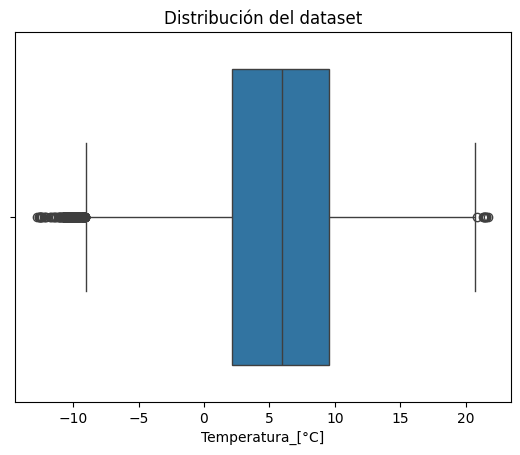

Temperatura mínima: -12.72700023651123
Temperatura máxima: 21.72300148010254


In [12]:
#Boxplot de la variable Temperatura
sns.boxplot(x=df['Temperatura_[°C]'])
plt.title('Distribución del dataset')
plt.show()
min_temp = df['Temperatura_[°C]'].min()
max_temp = df['Temperatura_[°C]'].max()
print(f'Temperatura mínima: {min_temp}')
print(f'Temperatura máxima: {max_temp}')

Aunque se presente datos atipicos de temperatura indicada en los minimos y maximos valores esto no se considera el hecho de que se tenga que descartar dichos valores, ya que son temperaturas que puede alcanzar la isla en las estaciones de invierno (para temperaturas inferiores a los 0°C) y verano (temperaturas superiores a los 20°C).

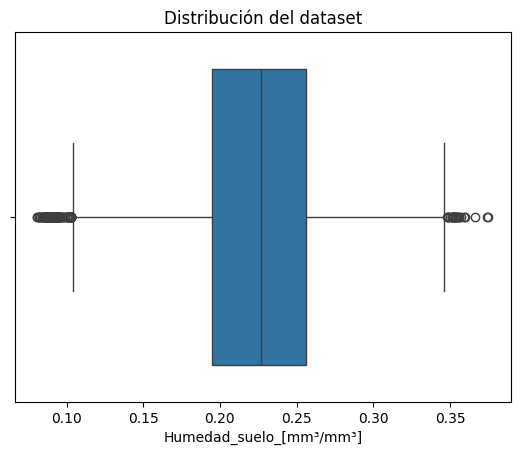

Humedad del suelo mínima: 0.08100000023841858
Humedad del suelo máxima: 0.375


In [13]:
#Boxplot de la variable Humedad del suelo
sns.boxplot(x=df['Humedad_suelo_[mm³/mm³]'])
plt.title('Distribución del dataset')
plt.show()
min_hum_suelo = df['Humedad_suelo_[mm³/mm³]'].min()
max_hum_suelo = df['Humedad_suelo_[mm³/mm³]'].max()
print(f'Humedad del suelo mínima: {min_hum_suelo}')
print(f'Humedad del suelo máxima: {max_hum_suelo}')

Los outliers tambien como en el boxplot de temperatura tambien no son descartados de este estudio ya que no son datos que sesguen al modelo

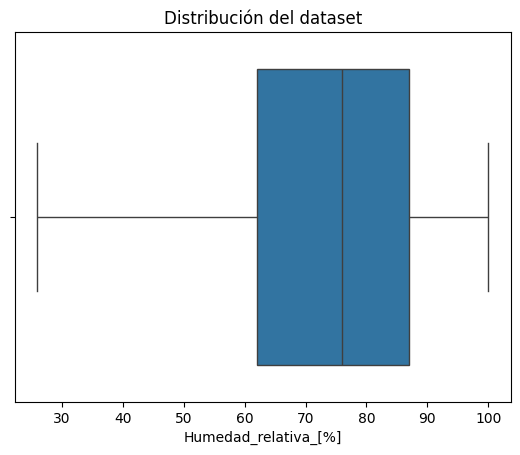

Humedad relativa mínima: 26.0
Humedad relativa máxima: 100.0


In [14]:
#Boxplot de la variable Humedad relativa
sns.boxplot(x=df['Humedad_relativa_[%]'])
plt.title('Distribución del dataset')
plt.show()
min_hum_rel = df['Humedad_relativa_[%]'].min()
max_hum_rel = df['Humedad_relativa_[%]'].max()
print(f'Humedad relativa mínima: {min_hum_rel}')
print(f'Humedad relativa máxima: {max_hum_rel}')

Se puede observar que rango de humedad en la isla ronda entre los 60% y 85% de humedad,aunque en los valores extremos nos encontramos con dias muy secos de 26% y muy humedos llegando al 100% pero no se encuentran datos atipicos que sobrepasen los bigotes. El hecho de que la mediana y la mayoría de los datos estén por encima del 70% muestra que Tierra del Fuego tiene un clima bastante húmedo en los datos obenidos para el desarrollo del proyecto.

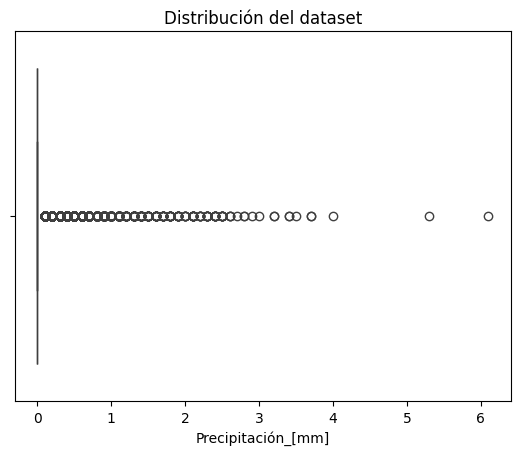

Precipitación mínima: 0.0
Precipitación máxima: 6.099999904632568


In [15]:
#Boxplot de la variable Precipitacion
sns.boxplot(x=df['Precipitación_[mm]'])
plt.title('Distribución del dataset')
plt.show()
min_prec = df['Precipitación_[mm]'].min()
max_prec = df['Precipitación_[mm]'].max()
print(f'Precipitación mínima: {min_prec}')
print(f'Precipitación máxima: {max_prec}')

Este quizas sea la caracteristica que describe bien a la isla ya que lo que describe es que la gran mayoria de los dias no hay presencia de lluvias, pero esto no indica que siempre sucede. Existen dias que si hay precipitaciones pero son pocos y muy atipicos, es por eso que el grafico muestra esta forma. Indicando que no suele llover muy frecuente en la isla y si suceden, no son muy abundantes. Hablamos de una cantidad de 6mm maximo para el rango de datos obtenidos.

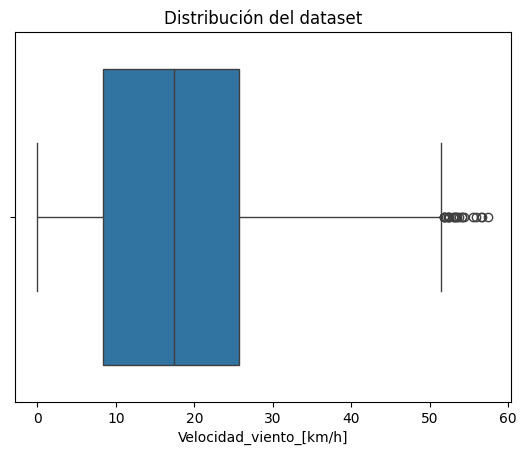

Velocidad del viento mínima: 0.0
Velocidad del viento máxima: 57.46145248413086


In [16]:
#Boxplot de la variable Velocidad del viento
sns.boxplot(x=df['Velocidad_viento_[km/h]'])
plt.title('Distribución del dataset')
plt.show()
min_vel_viento = df['Velocidad_viento_[km/h]'].min()
max_vel_viento = df['Velocidad_viento_[km/h]'].max()
print(f'Velocidad del viento mínima: {min_vel_viento}')
print(f'Velocidad del viento máxima: {max_vel_viento}')

Aqui se puede consideraar los datos atipicos ya que la isla presenta dias que superan el rango maximo de este grafico. Llegando a velocidades superiores a 100km/h. Principalmente en la zona costera y norte de la isla.

<Axes: >

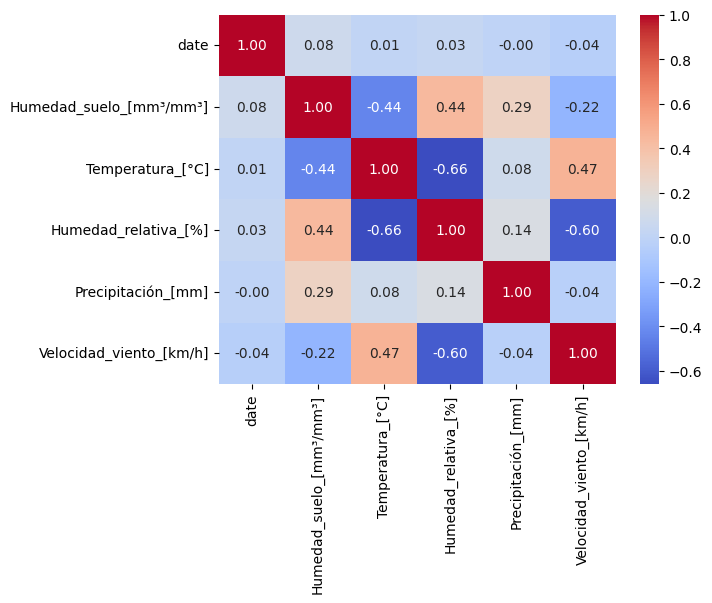

In [17]:
# Mapa de calor de correlación
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")

Vemos en el mapa de calor que las caracteristicas no tienen una correlacion alta para relacionarlas entre si, es decir, que cada variable no sigue una colinealidad o relacion lineal lo suficientemente significativa y no hay una dependencia fuerte entre ellas

# Regla para etiquetar la variable obtetivo

Ahora aplicaremos diferentes reglas o lógicas para etiquetar los datos a partir de los diferentes calculos para obtencion del Indice FWI y compararemos cual es la mejor para procesar a entrenarlo.

## **Regla n°1**

Esta regla no utiliza el indice de riesgo de incendio forestal FWI sino que utiliza una Lógica heurística para asignar la gravedad de incendio utilizando un sistema de puntuación de riesgo, donde cada variable suma puntos de peligro. Luego se asigna la categoría de gravedad según el total.

Si la suma total da lo siguiente:

| Puntos Totales | Gravedad  |
| -------------- | --------- |
| 0 – 3          | **Baja**  |
| 4 – 5          | **Media** |
| 6 – 10         | **Alta**  |

Esta regla no se requiere de utilizar la caracteristica de fecha, solo de los datos meteorologicos, por lo que no es necesario tenerlo contemplada y se lo elimina

In [107]:
#Eliminar columna date del dataframe
df=df.drop('date', axis=1)
df=df.copy()

In [108]:
def calcular_gravedad(row):
    # Temperatura
    if row['Temperatura_[°C]'] >= 25:
        temp_pts = 2
    elif row['Temperatura_[°C]'] >= 20:
        temp_pts = 1
    else:
        temp_pts = 0

    # Humedad relativa
    if row['Humedad_relativa_[%]'] < 30:
        humrel_pts = 2
    elif row['Humedad_relativa_[%]'] <= 50:
        humrel_pts = 1
    else:
        humrel_pts = 0

    # Precipitación
    if row['Precipitación_[mm]'] < 1:
        prec_pts = 2
    elif row['Precipitación_[mm]'] <= 5:
        prec_pts = 1
    else:
        prec_pts = 0

    # Humedad del suelo
    if row['Humedad_suelo_[mm³/mm³]'] < 0.15:
        humsuelo_pts = 2
    elif row['Humedad_suelo_[mm³/mm³]'] <= 0.25:
        humsuelo_pts = 1
    else:
        humsuelo_pts = 0

    # Viento
    if row['Velocidad_viento_[km/h]'] >= 25:
        viento_pts = 2
    elif row['Velocidad_viento_[km/h]'] >= 15:
        viento_pts = 1
    else:
        viento_pts = 0

    # Suma total de puntos
    puntos_totales = temp_pts + humrel_pts + prec_pts + humsuelo_pts + viento_pts

    # Clasificación de gravedad
    if puntos_totales >= 6:
        return 'Alta'
    elif puntos_totales >= 4:
        return 'Media'
    else:
        return 'Baja'

In [109]:
df['Riesgo'] = df.apply(calcular_gravedad, axis=1)

In [110]:
df[['Temperatura_[°C]', 'Humedad_relativa_[%]', 'Precipitación_[mm]', 'Humedad_suelo_[mm³/mm³]', 'Velocidad_viento_[km/h]', 'Riesgo']]

,Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Humedad_suelo_[mm³/mm³],Velocidad_viento_[km/h],Riesgo
5,6.273000,63.0,0.0,0.191,20.780453,Media
6,6.273000,64.0,0.0,0.190,20.380579,Media
7,7.023000,60.0,0.0,0.190,22.530937,Media
8,8.023000,55.0,0.0,0.189,27.193705,Media
9,8.672999,53.0,0.0,0.187,26.400545,Media
...,...,...,...,...,...,...
22027,-1.327000,84.0,0.0,0.242,3.545589,Baja
22028,-1.827000,88.0,0.0,0.242,3.826853,Baja
22029,-2.227000,91.0,0.0,0.242,4.104631,Baja
22030,-2.177000,92.0,0.0,0.242,3.826853,Baja


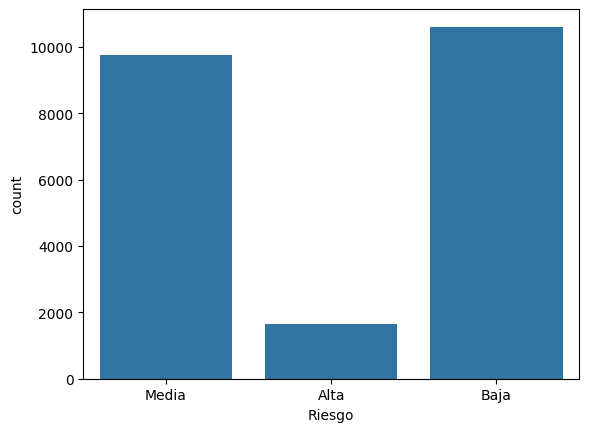

In [111]:
# Gráfico de barras de Estado de Cuenta
sns.countplot(x=df["Riesgo"])
plt.show()

In [112]:
df.groupby("Riesgo").count()

,Humedad_suelo_[mm³/mm³],Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h]
Riesgo,,,,,
Alta,1652,1652,1652,1652,1652
Baja,10606,10606,10606,10606,10606
Media,9769,9769,9769,9769,9769


Se ve una una buena distribucion de las categorias ya que se reducen las categorias a 3 cantidades lo cual es una logica un poco mas sencilla pero con la desventaja de no tener respaldo de fuentes o que se aplique en organizaciones y servicios importantes.

## **Regla n°2**

Para esta situacion se aplica una función que calcula un indice que mide el nivel de peligrosidad de los incendios forestales cuyo nombre es FWI (Forest Weather Index), propuesto en Canadá y se calcula segun caracteristicas que necesita el mismo para ser procesada que son:
1.   Fine Fuel Moisture Code (FFMC)
1.   Initial Spread Index (ISI)
2.   Build-Up Index (BUI)

cuyos calculos son los siguientes:

FFMC = 101 - 0,75*Humedad + 0,5*Temperatura

ISI = Viento*(FFMC/50)

BUI = (0,4*Temperatura) + (-0,2*Precipitacion) + 5

FWI = ISI * BUI

Despues analiza el resultado FWI obtenido y aplica una regla para asignar a que categoria de riesgo le pertenece cuya regla es la siguiente:

| FWI     | Riesgo de incendio |
| ------- | ------------------ |
| 0 - 5   | Bajo               |
| 5 - 12  | Moderado           |
| 12 - 30 | Alto               |
| 30 - 50 | Muy alto           |
| > 50    | Extremo            |

Como vemos no se requiere de utilizar la columna de Humedad volumetrica del suelo por lo que eliminamos por completo del dataframe

In [113]:
#Eliminamos por completo la columna de humedad volumetrica del suelo del dataframe
df=df.drop('Humedad_suelo_[mm³/mm³]', axis=1)
df=df.copy()

In [114]:
def calcular_fwi(temp, humedad_rel, precip, viento):
    ffmc = 101 - 0.75 * humedad_rel + 0.5 * temp
    isi = viento * (ffmc / 50)
    bui = (temp * 0.4) + (precip * -0.2) + 5
    fwi = isi * bui / 2  # Fórmula simplificada
    # Clasificación del nivel de riesgo
    if fwi <= 5:
        nivel_riesgo= 'Bajo'
    elif fwi <= 12:
        nivel_riesgo= 'Moderado'
    elif fwi <= 30:
        nivel_riesgo= 'Alto'
    elif fwi <= 50:
        nivel_riesgo= 'Muy alto'
    else:
        nivel_riesgo= 'Extremo'

    return fwi, nivel_riesgo

In [115]:
# Aplicar la función al dataset
df[['FWI', 'Riesgo']] = df.apply(lambda row: calcular_fwi(row['Temperatura_[°C]'], row['Humedad_relativa_[%]'], row['Precipitación_[mm]'], row['Velocidad_viento_[km/h]']), axis=1, result_type="expand")
df[['Temperatura_[°C]', 'Humedad_relativa_[%]', 'Precipitación_[mm]', 'Velocidad_viento_[km/h]', 'FWI', 'Riesgo']]

,Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h],FWI,Riesgo
5,6.273000,63.0,0.0,20.780453,88.768296,Extremo
6,6.273000,64.0,0.0,20.380579,85.912333,Extremo
7,7.023000,60.0,0.0,22.530937,104.709646,Extremo
8,8.023000,55.0,0.0,27.193705,142.340252,Extremo
9,8.672999,53.0,0.0,26.400545,146.645832,Extremo
...,...,...,...,...,...,...
22027,-1.327000,84.0,0.0,3.545589,5.916321,Moderado
22028,-1.827000,88.0,0.0,3.826853,5.568916,Moderado
22029,-2.227000,91.0,0.0,4.104631,5.336050,Moderado
22030,-2.177000,92.0,0.0,3.826853,4.884586,Bajo


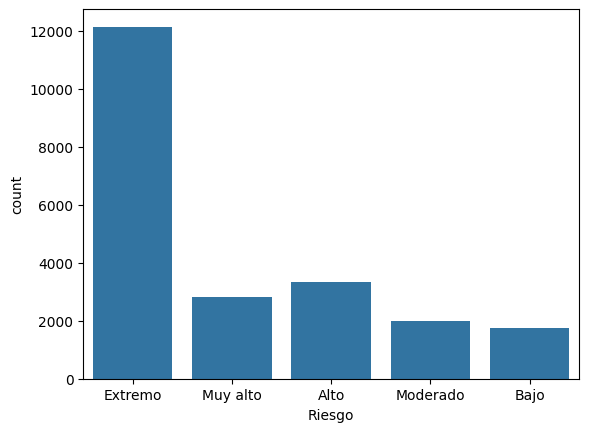

In [116]:
# Gráfico de barras de Estado de Cuenta
sns.countplot(x=df["Riesgo"])
plt.show()

In [117]:
df.groupby("Riesgo").count()

,Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h],FWI
Riesgo,,,,,
Alto,3323,3323,3323,3323,3323
Bajo,1736,1736,1736,1736,1736
Extremo,12141,12141,12141,12141,12141
Moderado,2005,2005,2005,2005,2005
Muy alto,2822,2822,2822,2822,2822


Esta regla se puede concluir que hay muchas categorias que la regla anterior, lo cual hace que se pueda distribuir mas las situaciones a medida que hay mas niveles. La desventaja de esta regla es que persiste muchos los casos de niveles extremos de incendio. Con un orden del indice de los 103. Lo que se puede decir que esta regla no es muy optima para la asignacion de las categorias.

# **Regla n°3**

Esta regla utiliza una formula simplificada de la obtencion del indice de incendio forestal y que es aceptada por el servicio meteoroligco nacional, el cual se calcula de la siguiente manera:

FWI=0.1⋅**T**+0.2**⋅V**+0.3⋅(100−**H**)+0.5.**P**

Donde:
*   T = Temperatura (°C)
*   V = Velocidad del viento (km/h)
*   H = Humedad relativa (%)
*   P = Precipitacion (mm)

Y luego calculado clasifica el riesgo con una funcion el cual considera las siguientes logicas:

| FWI     | Riesgo de incendio |
| ------- | ------------------ |
| 0 - 5   | Bajo               |
| 5 - 12  | Moderado           |
| 12 - 30 | Alto               |
| 30 - 50 | Muy alto           |
| > 50    | Extremo            |

In [118]:
# Función para clasificar el nivel de riesgo según FWI
def clasificar_riesgo(fwi):
    if fwi <= 5:
        return 'Bajo'
    elif fwi <= 12:
        return 'Moderado'
    elif fwi <= 30:
        return 'Alto'
    elif fwi <= 50:
        return 'Muy alto'
    else:
        return 'Extremo'

#Funcion para calcular FWI
def calcular_FWI(temp, humedad_rel, precip, viento):
    fwi = 0.1 * temp + 0.2 * viento + 0.3 * (100 - humedad_rel) + 0.5 * precip
    return fwi

In [119]:
# Aplicar la función a cada fila del DataFrame
df['FWI'] = df.apply(lambda row: calcular_FWI(
    row['Temperatura_[°C]'],
    row['Humedad_relativa_[%]'],
    row['Precipitación_[mm]'],
    row['Velocidad_viento_[km/h]']
), axis=1)

df['Riesgo'] = df['FWI'].apply(clasificar_riesgo)

In [120]:
df[['Temperatura_[°C]', 'Humedad_relativa_[%]', 'Precipitación_[mm]', 'Velocidad_viento_[km/h]', 'FWI', 'Riesgo']]

,Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h],FWI,Riesgo
5,6.273000,63.0,0.0,20.780453,15.883391,Alto
6,6.273000,64.0,0.0,20.380579,15.503416,Alto
7,7.023000,60.0,0.0,22.530937,17.208487,Alto
8,8.023000,55.0,0.0,27.193705,19.741041,Alto
9,8.672999,53.0,0.0,26.400545,20.247409,Alto
...,...,...,...,...,...,...
22027,-1.327000,84.0,0.0,3.545589,5.376418,Moderado
22028,-1.827000,88.0,0.0,3.826853,4.182671,Bajo
22029,-2.227000,91.0,0.0,4.104631,3.298226,Bajo
22030,-2.177000,92.0,0.0,3.826853,2.947671,Bajo


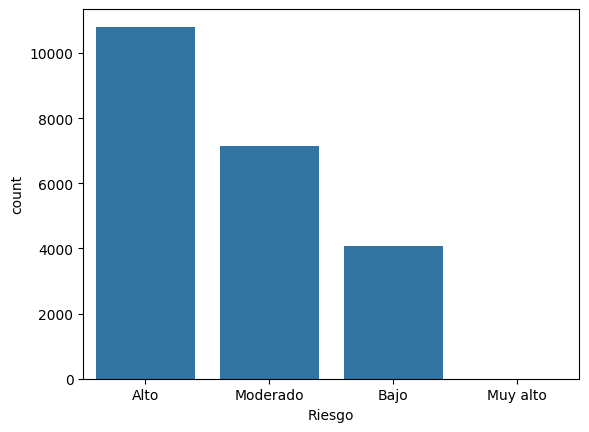

In [121]:
# Gráfico de barras de Estado de Cuenta
sns.countplot(x=df["Riesgo"])
plt.show()

In [122]:
df.groupby("Riesgo").count()

,Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h],FWI
Riesgo,,,,,
Alto,10808,10808,10808,10808,10808
Bajo,4086,4086,4086,4086,4086
Moderado,7131,7131,7131,7131,7131
Muy alto,2,2,2,2,2


Esta regla tiene una buena forma de asignacion de las categorias ya que distribuye y analiza mejor las situaciones. Por lo que se puede considerar una posible adopcion para aplicar a este modelo.

## **Regla n°4**

Esta regla es similar a la **Regla 2** con la particularidad que tiene una consideracion en el valor de *Precipitacion* ya que existen muchos datos sin lluvia, es decir, 0 mm de precipitacion. Por lo que la regla sugiere hacer un ajuste con un factor y condicion de:

5 si Precipitación < 0.2 mm (condiciones secas)

0 si Precipitación ≥ 0.2 mm

Esta fórmula da resultados más equilibrados y ajustados a condiciones meteorológicas reales.

Luego aplica la asignacion de la categoria mediante la siguiente condicion:

| FWI     | Clasificación de riesgo |
| ------- | ----------------------- |
| 0 - 8   | Bajo                    |
| 8 - 15  | Moderado                |
| 15 - 30 | Alto                    |
| 30 - 46 | Muy alto                |
| > 46    | Extremo                 |


In [123]:
def calcular_fwi(temp, humedad_rel, precip, viento):
    # Factor por baja precipitación

    if precip < 0.2:
      precip_factor = 5
    else:
      precip_factor = 0

    # Fórmula corregida y calibrada
    fwi = (0.048 * temp) + (0.644 * viento) + (0.118 * (100 - humedad_rel)) + precip_factor

    # Clasificación del nivel de riesgo
    if fwi < 8:
        nivel_riesgo = 'Bajo'
    elif fwi < 15:
        nivel_riesgo = 'Moderado'
    elif fwi < 28:
        nivel_riesgo = 'Alto'
    elif fwi < 46:
        nivel_riesgo = 'Muy alto'
    else:
        nivel_riesgo = 'Extremo'
    return fwi, nivel_riesgo


In [124]:
# Aplicar la función al dataset
df[['FWI', 'Riesgo']] = df.apply(lambda row: calcular_fwi(row['Temperatura_[°C]'], row['Humedad_relativa_[%]'], row['Precipitación_[mm]'], row['Velocidad_viento_[km/h]']), axis=1, result_type="expand")
df[['Temperatura_[°C]', 'Humedad_relativa_[%]', 'Precipitación_[mm]', 'Velocidad_viento_[km/h]', 'FWI', 'Riesgo']]

,Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h],FWI,Riesgo
5,6.273000,63.0,0.0,20.780453,23.049716,Alto
6,6.273000,64.0,0.0,20.380579,22.674197,Alto
7,7.023000,60.0,0.0,22.530937,24.567028,Alto
8,8.023000,55.0,0.0,27.193705,28.207850,Muy alto
9,8.672999,53.0,0.0,26.400545,27.964255,Alto
...,...,...,...,...,...,...
22027,-1.327000,84.0,0.0,3.545589,9.107663,Moderado
22028,-1.827000,88.0,0.0,3.826853,8.792797,Moderado
22029,-2.227000,91.0,0.0,4.104631,8.598487,Moderado
22030,-2.177000,92.0,0.0,3.826853,8.303997,Moderado


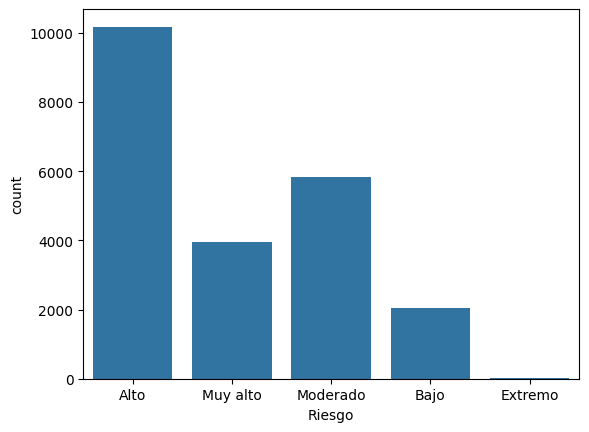

In [125]:
# Gráfico de barras de Estado de Cuenta
sns.countplot(x=df["Riesgo"])
plt.show()

In [126]:
df.groupby("Riesgo").count()

,Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h],FWI
Riesgo,,,,,
Alto,10179,10179,10179,10179,10179
Bajo,2058,2058,2058,2058,2058
Extremo,10,10,10,10,10
Moderado,5825,5825,5825,5825,5825
Muy alto,3955,3955,3955,3955,3955


Esta es quizas la regla que mejor se ajusta para el problema, por un lado porque distribuye y asigna mejor las categorias y por otro lado porque estan presentes todos los niveles de peligrosidad, con un grado reducido en los niveles "Extremo" pero de igual forma permite tener un entrenamiento considerando todas las etiquetas.

Asi que esta es la Regla que se utilizará para el proceso de entrenamiento del modelo

In [136]:
#Reordenamos el dataframe para realizar la copia y exportacion del archivo
df=df[['Temperatura_[°C]', 'Humedad_relativa_[%]', 'Precipitación_[mm]', 'Velocidad_viento_[km/h]', 'FWI', 'Riesgo']]
df #Mostramos el dataframe para ver el orden de las columnas

,Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h],FWI,Riesgo
5,6.273000,63.0,0.0,20.780453,23.049716,Alto
6,6.273000,64.0,0.0,20.380579,22.674197,Alto
7,7.023000,60.0,0.0,22.530937,24.567028,Alto
8,8.023000,55.0,0.0,27.193705,28.207850,Muy alto
9,8.672999,53.0,0.0,26.400545,27.964255,Alto
...,...,...,...,...,...,...
22027,-1.327000,84.0,0.0,3.545589,9.107663,Moderado
22028,-1.827000,88.0,0.0,3.826853,8.792797,Moderado
22029,-2.227000,91.0,0.0,4.104631,8.598487,Moderado
22030,-2.177000,92.0,0.0,3.826853,8.303997,Moderado


In [137]:
#Guardamos el dataframe
df.to_csv("dataset_con_riesgo.csv", index=False)